In [2]:
import uavgeo as ug
import geopandas as gpd
import rioxarray
import numpy as np
import ultralytics
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

c:\users\judoj\documents\programming\uavgeo\uavgeo\compute\products.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# DEM DSM DTM CHM Creation from DEM metashape
1. load DSM
2. create 1m square grid
3. find local minima in every square
4. assume it is the correct ground measurement
5. burn back into a dem

6. Make it a uavgeo feature to create DEMs and CHMs from DSMs

In [2]:
# load data
#QGIS: rgb pixelsize = 0.018
rgb_2022_dsm = rxr.open_rasterio("../data/orthos/rgb_2022_dsm.tif",mode = "w")
#fix NAN values
rgb_2022_dsm = rgb_2022_dsm.where(rgb_2022_dsm.values !=-32767.)
#QGIS: ms pixelsize = 0.027
ms_2022_dsm = rxr.open_rasterio("../data/orthos/ms_2022_dsm.tif",mode = "w")
ms_2022_dsm = ms_2022_dsm.where(ms_2022_dsm.values !=-32767.)

In [6]:
pixel_size = rgb_2022_dsm.rio.resolution()[0]
# or use
pixel_size = 0.018


sampling_meters = 1

#function will take a bit longer than the progress bar shows
dem = ug.compute.calc_dem_from_dsm(rgb_2022_dsm, pixel_size, sampling_meters)


  0%|          | 0/42846 [00:00<?, ?it/s]

c:\users\judoj\documents\programming\uavgeo\uavgeo\compute\products.py:34: RuntimeWarning: All-NaN axis encountered
  sampling_grid["h"] = sampling_grid.progress_apply(lambda x: np.nanmin(dsm.rio.clip_box(minx = x.geometry.bounds[0],


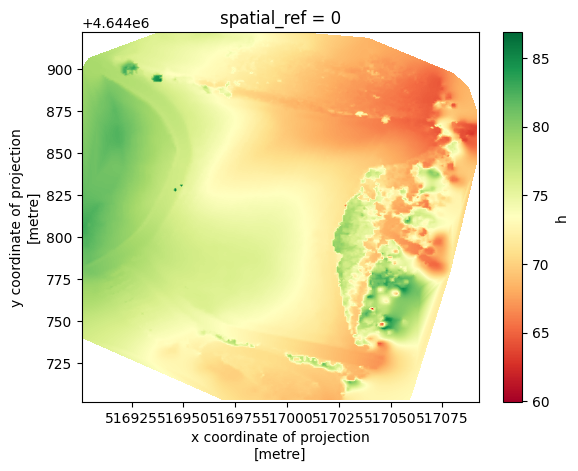

In [7]:
# it already looks really good at 1 meters tho!
dem.plot( cmap = "RdYlGn")

In [45]:
dem.rio.to_raster("../data/orthos/rgb_2022_dem.tif")

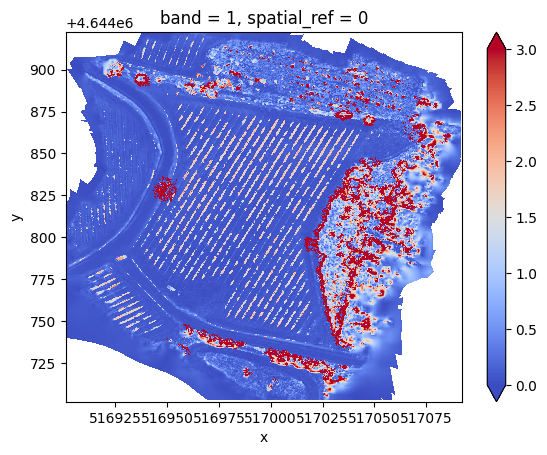

In [11]:
chm = rgb_2022_dsm - dem
chm.plot(cmap ="coolwarm",vmin=0.2, vmax=3)

In [9]:
chm.rio.to_raster("../data/orthos/rgb_2022_chm.tif")

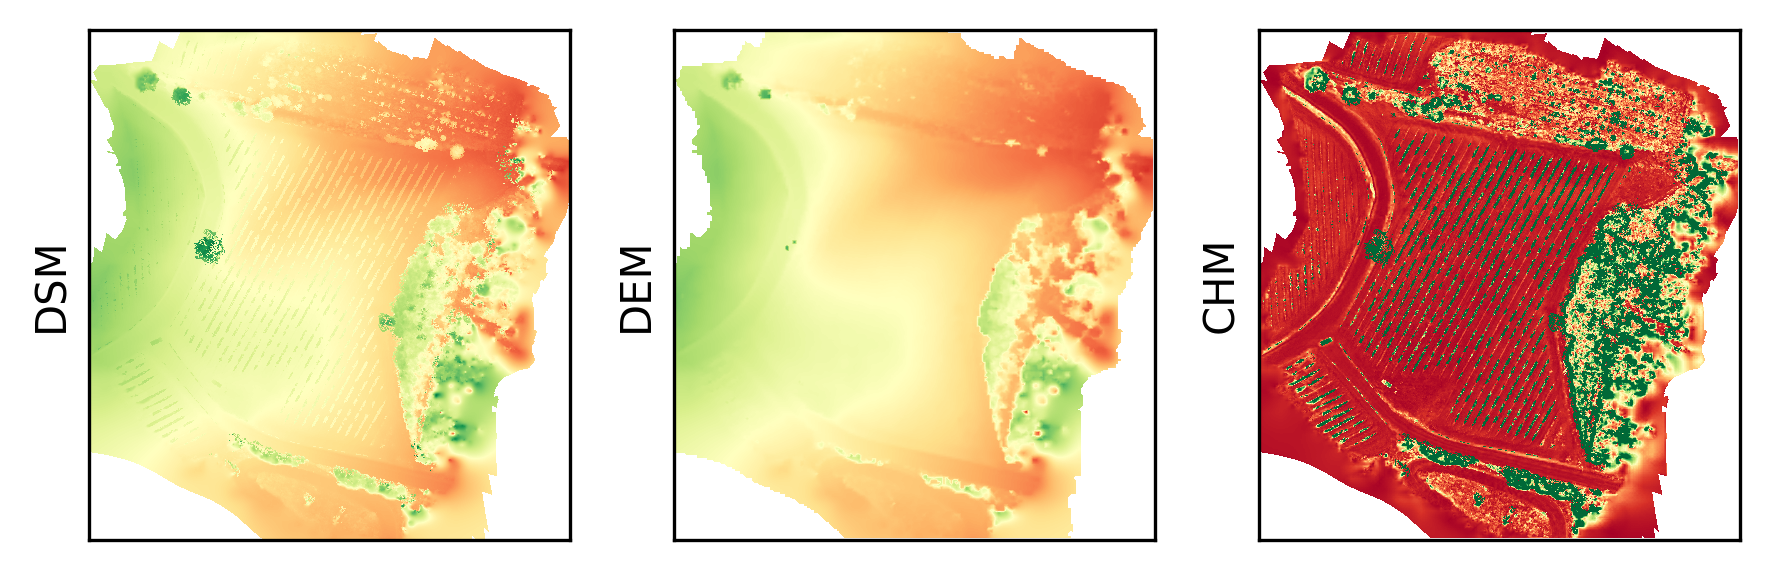

In [2]:
dsm = rxr.open_rasterio("../data/orthos/rgb_2022_dsm.tif",mode = "w")
dsm = dsm.where(dsm.values !=-32767.)
dem = rxr.open_rasterio("../data/orthos/rgb_2022_dem.tif",mode = "w")
chm = rxr.open_rasterio("../data/orthos/rgb_2022_chm.tif",mode = "w")

fig,ax = plt.subplots(figsize=(6,2),nrows =1, ncols = 3,dpi=300)

dsm.plot(ax=ax[0],cmap = "RdYlGn", vmin =60, vmax =90,add_colorbar=False)
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("DSM")

dem.plot(ax=ax[1], cmap ="RdYlGn",vmin=60, vmax=90,add_colorbar=False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("DEM")


chm.plot(ax=ax[2], cmap ="RdYlGn",vmin=0, vmax=1.5,add_colorbar=False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("CHM")

plt.tight_layout()
plt.savefig("figures/BTG2022_dsm_dem_chm.png")
plt.show()

# rinse repeat for Canyelles

In [3]:
can_2023_dsm = rxr.open_rasterio("../data/canyelles/orthos/dem_230609.tif", chunks=True, mode = "w")
can_2023_dsm = can_2023_dsm.where(can_2023_dsm.values !=-32767.)
#original raster is in crs 4326 aka WGS84
# WGS84 has degrees instead of meters
# and I cant be bothered to do the conversion
can_2023_dsm = can_2023_dsm.rio.reproject("EPSG:32631")

In [4]:
can_2023_dsm.rio.to_raster("../data/canyelles/orthos/can_2023_dsm.tif")

In [5]:
pixel_size

NameError: name 'pixel_size' is not defined

In [6]:
#original raster is in crs 4326 aka WGS84
# WGS84 has degrees instead of meters
pixel_size = can_2023_dsm.rio.resolution()[0]
sampling_meters = 1

#function will take a bit longer than the progress bar shows
can_2023_dem = ug.compute.calc_dem_from_dsm(can_2023_dsm, pixel_size, sampling_meters)

  0%|          | 0/45276 [00:00<?, ?it/s]

c:\users\judoj\documents\programming\uavgeo\uavgeo\compute\products.py:64: RuntimeWarning: All-NaN axis encountered
  sampling_grid["h"] = sampling_grid.progress_apply(lambda x: np.nanmin(dsm.rio.clip_box(minx = x.geometry.bounds[0],


In [7]:
can_2023_dem.rio.to_raster("../data/canyelles/orthos/can_2023_dem.tif")

In [8]:
can_2023_chm = can_2023_dsm - can_2023_dem
#can_2023_chm.plot(cmap ="coolwarm",vmin=0.2, vmax=3)

In [9]:
can_2023_chm.rio.to_raster("../data/canyelles/orthos/can_2023_chm.tif")

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


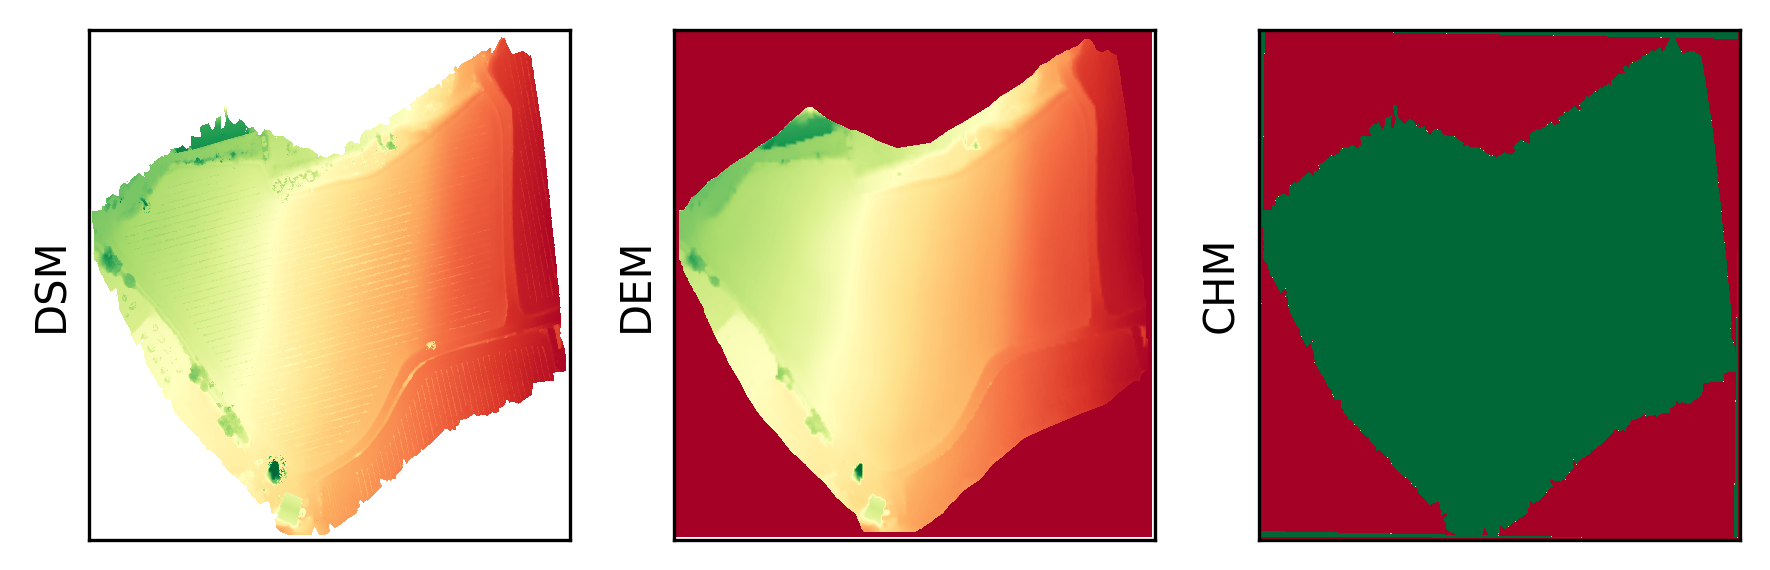

In [12]:
dsm = rxr.open_rasterio("../data/canyelles/orthos/can_2023_dsm.tif")
dem = rxr.open_rasterio("../data/canyelles/orthos/can_2023_dem.tif")
chm = rxr.open_rasterio("../data/canyelles/orthos/can_2023_chm.tif")


chm = ug.compute.rescale_floats(chm)


from rasterio.enums import Resampling

upscale_factor =0.1
new_width = chm.rio.width * upscale_factor
new_height = chm.rio.height * upscale_factor


dem_down =dem.rio.reproject(
    chm.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)

dsm_down =dsm.rio.reproject(
    chm.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)

chm_down =chm.rio.reproject(
    chm.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    
)

fig,ax = plt.subplots(figsize=(6,2),nrows =1, ncols = 3,dpi=300)

dsm_down.plot(ax=ax[0],cmap = "RdYlGn", vmin =199, vmax =220,add_colorbar=False)
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("DSM")

dem_down.plot(ax=ax[1], cmap ="RdYlGn",vmin=199, vmax=220,add_colorbar=False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("DEM")


chm_down.plot(ax=ax[2], cmap ="RdYlGn",vmin=0, vmax=1.5,add_colorbar=False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("CHM")

plt.tight_layout()
plt.savefig("figures/can2023_dsm_dem_chm.png")
plt.show()

## Repeat for BTG2021 test

In [3]:
# load data
#QGIS: rgb pixelsize = 0.018
dsm_2021 = rxr.open_rasterio("../data/orthos/dsm_2021.tif",mode = "w")
#fix NAN values



In [4]:
dsm_2021.rio.resolution()[0]

0.01669269999999784

In [5]:
pixel_size = dsm_2021.rio.resolution()[0]
# or use
#pixel_size = 0.01669


sampling_meters = 1

#function will take a bit longer than the progress bar shows
dem = ug.compute.calc_dem_from_dsm(dsm_2021, pixel_size, sampling_meters)


  0%|          | 0/39550 [00:00<?, ?it/s]

In [6]:
dem.rio.to_raster("../data/orthos/btg_2021_dem.tif")

In [7]:
chm = dsm_2021 - dem
chm.rio.to_raster("../data/orthos/btg_2021_chm2.tif")

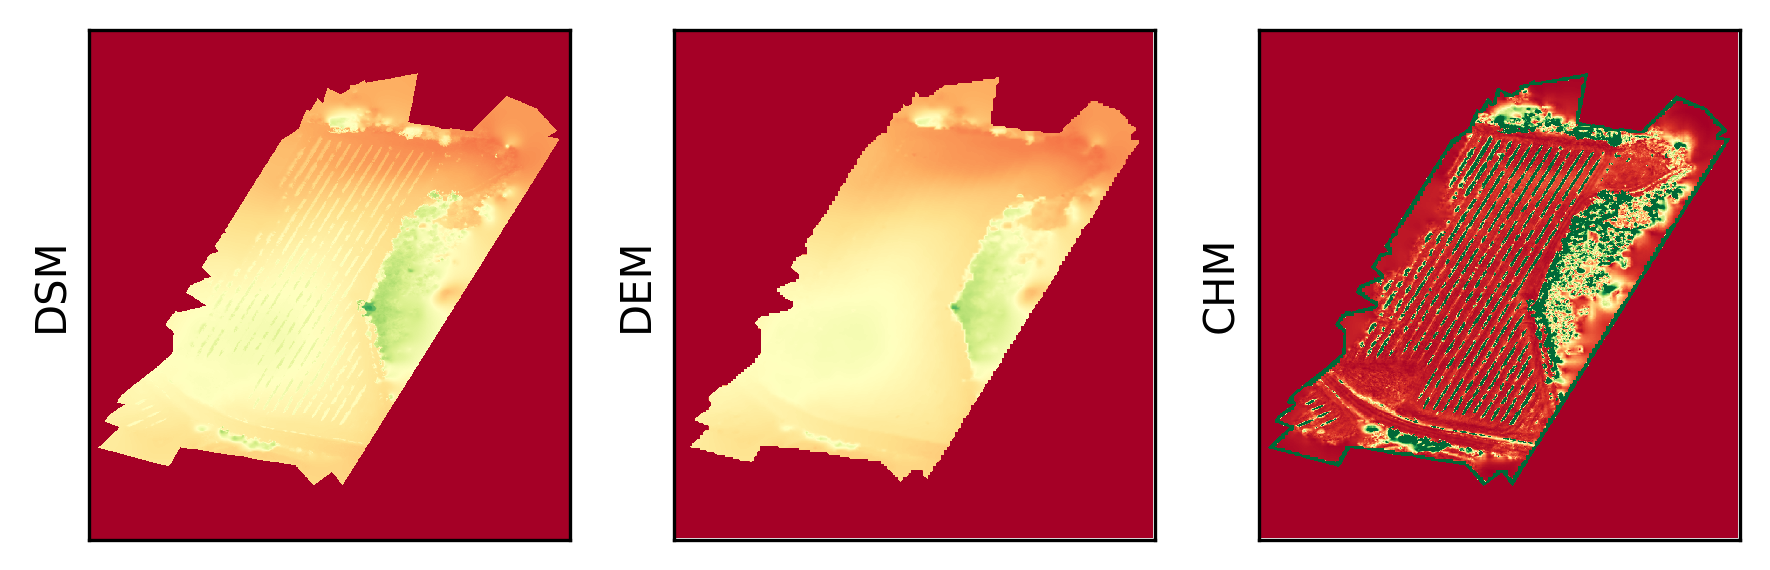

In [8]:
dsm = rxr.open_rasterio("../data/orthos/dsm_2021.tif")
dem = rxr.open_rasterio("../data/orthos/btg_2021_dem.tif")
chm = rxr.open_rasterio("../data/orthos/btg_2021_chm2.tif")


#chm = ug.compute.rescale_floats(chm)


from rasterio.enums import Resampling

upscale_factor =0.1
new_width = chm.rio.width * upscale_factor
new_height = chm.rio.height * upscale_factor


dem_down =dem.rio.reproject(
    chm.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=dem.rio.nodata
)

dsm_down =dsm.rio.reproject(
    chm.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=dsm.rio.nodata
)

chm_down =chm.rio.reproject(
    chm.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=chm.rio.nodata
    
)

fig,ax = plt.subplots(figsize=(6,2),nrows =1, ncols = 3,dpi=300)

dsm_down.plot(ax=ax[0],cmap = "RdYlGn", vmin =60, vmax =90,add_colorbar=False)
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("DSM")

dem_down.plot(ax=ax[1], cmap ="RdYlGn",vmin=60, vmax=90,add_colorbar=False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("DEM")


chm_down.plot(ax=ax[2], cmap ="RdYlGn",vmin=0, vmax=1,add_colorbar=False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("CHM")

plt.tight_layout()
plt.savefig("figures/btg_2021_dsm_dem_chm.png")
plt.show()